In [32]:
import numpy as np
import pandas as pd

from multiglm.data.dataset_loader import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next steps:

[X] move into a class

-- break -- 

[ ] integrate into experiment.py

* [X] fix imports in experiment.py

* [X] write a sub method get_data that takes in params. Look for params.animals and params.data_type. call this and return self.df

-- break -- 

* [X] integrate into generate design matrix for animal

    * [X] test with base class & debug (choice might be incorrect?)
    
    * [ ] test with experiment init

    * [ ] clean up experiment init (or at least write a full doc of all param options)


In [4]:
DatasetLoader.determine_load_function?

Signature: DatasetLoader.determine_load_function(self)
Docstring:
Given the data type requested by the user, determine the
appropriate function to load the data.

Options
-------
    - new_trained: Only trained (i.e. latest stage, full performance)
        data from the new dataset see `crated_trained_threshold_df.ipynb`
        for more info
    - new_all: All data from the new dataset
    - new_match_old_viols: New dataset truncated to session 200 to
        closely resemble the old dataset where violations stopped
        being tracked at session 200
    - old_viols: the old, public dataset until sessions stopped being
        tracked at session 200
Returns
-------
    function: The function to load the data
File:      ~/Desktop/github/animal-learning/src/multiglm/data/dataset_loader.py
Type:      function

In [7]:
dl = DatasetLoader()
df = dl.load_data()

Loading data for animal ids:  ['W051', 'W060', 'W061', 'W062', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


In [34]:
from multiglm.data import ANIMAL_IDS

ANIMAL_IDS

['W051',
 'W060',
 'W065',
 'W066',
 'W068',
 'W072',
 'W073',
 'W074',
 'W075',
 'W078',
 'W080',
 'W081',
 'W082',
 'W083',
 'W088',
 'W089',
 'W094']

In [12]:
from multiglm.features.design_matrix_generator import *

filter_params = {"prev_violation": 0}
dm = DesignMatrixGeneratorFilteredHistory()

In [14]:
X, y = dm.generate_design_matrix(df.query("animal_id == 'W051'"), filter_params)

X.head()

,bias,session,prev_violation,s_a,s_b,prev_sound_avg,prev_correct,prev_choice
0,1,326,0.0,-1.649967,-0.834803,0.000000,0.0,0.0
1,1,326,1.0,-1.649967,-0.834803,-0.000000,-0.0,2.0
2,1,326,1.0,0.019421,-0.834803,-0.000000,-0.0,2.0
3,1,326,1.0,-0.815273,0.000556,-0.000000,0.0,2.0
4,1,326,0.0,0.854115,0.000556,-0.445716,-1.0,1.0


In [15]:
pd.get_dummies(df["choice"])

,0,1,2
0,False,False,True
1,False,False,True
2,False,False,True
3,False,True,False
4,False,True,False
...,...,...,...
2144770,False,False,True
2144771,False,False,True
2144772,False,True,False
2144773,True,False,False


### Experiment

In [17]:
from multiglm.experiments.experiment import *
from multiglm.experiments.experiment_compare_models import *
from multiglm.models.multiclass_logistic_regression import *
from multiglm.data import ANIMAL_IDS


In [35]:
model_config = {
    "psytrack_features": {  # MODEL 1
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": -1},  # no filter & drop column
    },
    "prev_violation": {  # MODEL 2
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": 0},  # no filter
    },
}

params = {
    "animals": ANIMAL_IDS,
    "sigmas": [0.07, 0.13],  # , 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "null_mode": "multi",
    "eval_train": True,
    "tau_columns": ["prev_violation"],
    "model_config": model_config,
    "min_training_stage": 4,
}

In [36]:
experiment = ExperimentCompareModels(params)

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


In [37]:
experiment.run()

minimum training stage is  4

 >>>> evaluating animal W051 <<<<

 ***** evaluating model psytrack_features w/ sigma 0.07 *****
         Current function value: 64589.836270
         Iterations: 27
         Function evaluations: 43
         Gradient evaluations: 43

 ***** evaluating model psytrack_features w/ sigma 0.13 *****
         Current function value: 64579.411943
         Iterations: 23
         Function evaluations: 38
         Gradient evaluations: 38

 ***** evaluating model prev_violation w/ sigma 0.07 *****
         Current function value: 64403.116819
         Iterations: 25
         Function evaluations: 106
         Gradient evaluations: 93

 ***** evaluating model prev_violation w/ sigma 0.13 *****
         Current function value: 64378.393964
         Iterations: 24
         Function evaluations: 62
         Gradient evaluations: 50

 >>>> evaluating animal W060 <<<<

 ***** evaluating model psytrack_features w/ sigma 0.07 *****
         Current function value: 52716.

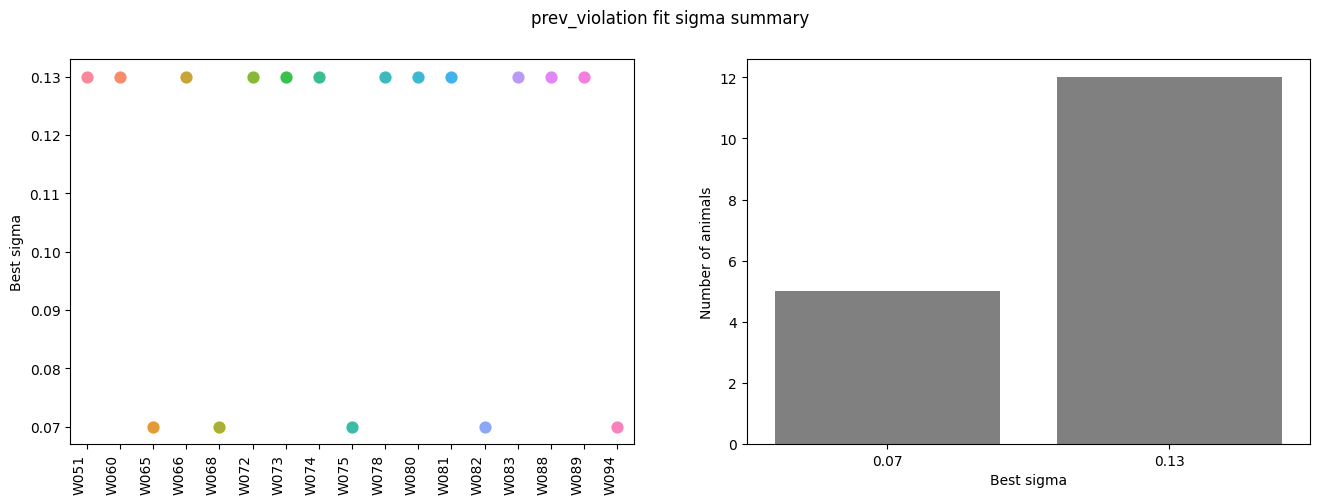

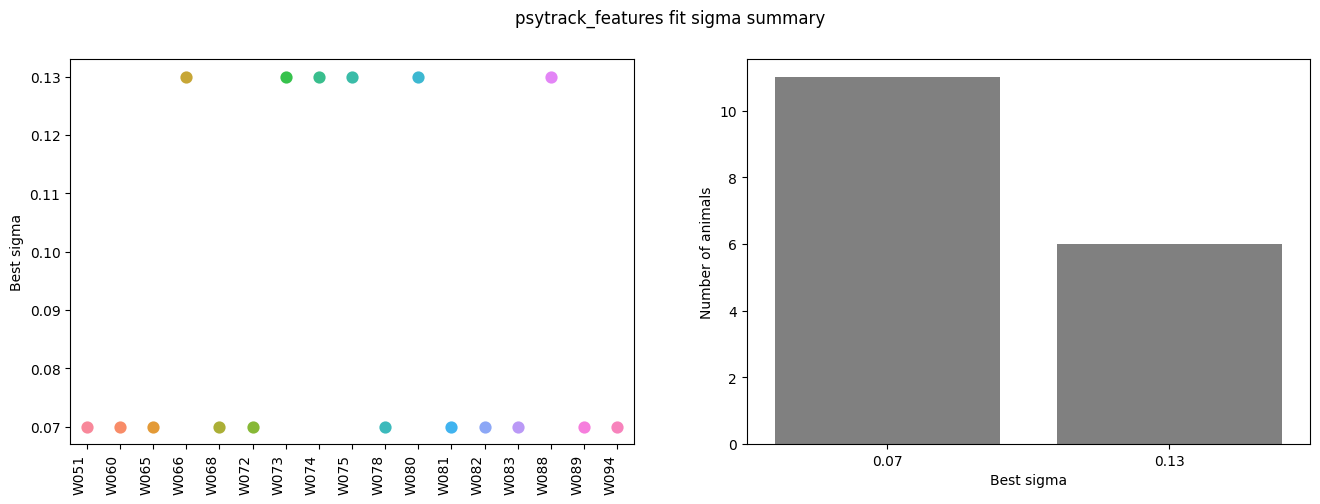

In [38]:
from multiglm.visualizations.model_visualizer import *

mvc = ModelVisualizerCompare(experiment)
df = mvc.find_best_fit(group="model_name")
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

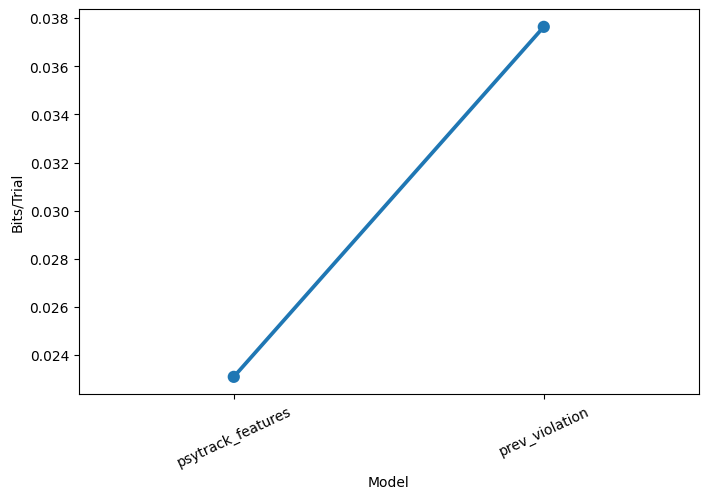

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=["psytrack_features", "prev_violation"],
    errorbar=None,
)